In [2]:
from Dataset import *
import cupy as cp
from bpnn_cuda import BPNN

def convert_categories(y_cat):
    desired = cp.array([0 if y[0] == 1 else 1 for y in y_cat])
    return desired

def get_data():
    d = Dataset.load_gzip(os.path.join("datasets", "face_mask_pickled"), "dataset_gray_conv.pkl.gzip")

    ndimen = d.train.X.shape[1]

    # Structure Training Data for BPNN
    training_inputs = [cp.reshape(cp.asarray(x), (ndimen, 1)) for x in d.train.X]
    training_results = [cp.asarray(y.reshape(-1, 1)) for y in d.train.y]

    training_data = zip(training_inputs, training_results)
    # Structure Validation Data for BPNN
    validation_inputs = [cp.reshape(cp.asarray(x), (ndimen, 1)) for x in d.validation.X]
    validation_data = zip(validation_inputs, convert_categories(d.validation.y))
    # Structure Testing Data for BPNN
    testing_inputs = [cp.reshape(cp.asarray(x), (ndimen, 1)) for x in d.test.X]
    testing_data = zip(testing_inputs, convert_categories(d.test.y))

    return training_data, validation_data, testing_data, ndimen


training_data, validation_data, testing_data, ndimen = get_data()
print(f"Input Dimension: {ndimen}")

ntrials = 1
max_epochs = 100
init_nc = [ndimen, 200, 2]
init_b = 40
init_lr = 0.5

Input Dimension: 3481


In [ ]:

model_BPNN = BPNN(init_nc, verbose=True)
final_score, eval_scores, eval_scores_deltas, conv_time = model_BPNN.train(training_data,
                                                                           max_epochs=max_epochs,
                                                                           batch_size=init_b,
                                                                           learning_rate=init_lr,
                                                                           evaluation_data=validation_data)


Training Epoch vs. Accuracy (Effect of Network Configuration)


100%|██████████| 100/100 [08:34<00:00,  5.15s/it]


[3481, 50, 2] => 0.82


100%|██████████| 100/100 [08:34<00:00,  5.14s/it]


[3481, 100, 2] => 0.8225


100%|██████████| 100/100 [08:28<00:00,  5.08s/it]


[3481, 200, 2] => 0.8225


100%|██████████| 100/100 [08:13<00:00,  4.94s/it]


[3481, 400, 2] => 0.8125


100%|██████████| 100/100 [08:33<00:00,  5.13s/it]


[3481, 800, 2] => 0.80375


100%|██████████| 100/100 [16:15<00:00,  9.75s/it]


[3481, 1600, 2] => 0.8225


100%|██████████| 100/100 [30:26<00:00, 18.26s/it]


[3481, 3200, 2] => 0.84125


100%|██████████| 100/100 [37:44<00:00, 22.65s/it]

[3481, 4000, 2] => 0.8425


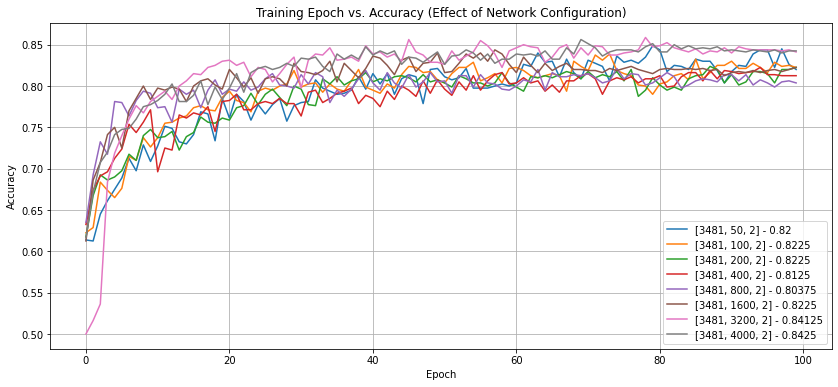

Best network configuration: [3481, 4000, 2]


In [3]:
def plot_accuracies_hidden_layers_and_nodes(save_dir, layers_arr):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Training Epoch vs. Accuracy (Effect of Network Configuration)")

    fig = plt.figure(figsize=(14, 6))
    plt.title(
        f"Training Epoch vs. Accuracy (Effect of Network Configuration)")
    plt.xlabel("Epoch")
    plt.ylabel('Accuracy')

    best_score = 0
    best_config = None

    for layers in layers_arr:
        final_scores = []
        epoch_scores = []
        # Run an average over multiple trials
        for i in range(ntrials):
            # Get data and train the network
            training_data, validation_data, testing_data, ndimen = get_data()
            nn = BPNN(layers, verbose=False)
            final_score, eval_scores, eval_scores_deltas, conv_time = nn.train(training_data,
                                                                               max_epochs=max_epochs,
                                                                               batch_size=init_b,
                                                                               learning_rate=init_lr,
                                                                               evaluation_data=validation_data,
                                                                               evaluation_treshold=None)
            final_scores.append(final_score)
            epoch_scores.append(eval_scores)

        # Compute the averages over the specified number of trials
        final_score_avg = np.average(final_scores)
        epoch_scores = np.mean(epoch_scores, axis=0)

        print(f'{layers} => {final_score_avg}')
        if final_score_avg > best_score:
            best_score = final_score_avg
            best_config = layers
        plt.plot(epoch_scores, label=f'{layers} - {final_score_avg}')

    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'{save_dir}/bpnn_layers_vs_acc', dpi=100)

    return best_config


layers_arr = [[ndimen, 50, 2],
              [ndimen, 100, 2],
              [ndimen, 200, 2],
              [ndimen, 400, 2],
              [ndimen, 800, 2],]


"""
# Generate all possible network combinations with the following criteria:
# - Minimum number of hidden layers: 1
# - Maximum number of hidden layers: 10
# - Minimum number of nodes in each hidden layer: 32
# - Maximum number of nodes in each hidden layer: 1024
# - Increments of 32
"""


best_nc = plot_accuracies_hidden_layers_and_nodes("img", layers_arr)
print(f"Best network configuration: {best_nc}")


Training Epoch vs. Accuracy (Effect of Batch Size)


100%|██████████| 100/100 [38:24<00:00, 23.05s/it]


20 => 0.8425


100%|██████████| 100/100 [37:55<00:00, 22.75s/it]


30 => 0.82875


100%|██████████| 100/100 [40:20<00:00, 24.20s/it]


35 => 0.8375


100%|██████████| 100/100 [41:49<00:00, 25.10s/it]


40 => 0.83625


100%|██████████| 100/100 [37:59<00:00, 22.80s/it]


45 => 0.8325


100%|██████████| 100/100 [37:36<00:00, 22.57s/it]


50 => 0.82875


100%|██████████| 100/100 [37:30<00:00, 22.51s/it]


60 => 0.8225


100%|██████████| 100/100 [37:26<00:00, 22.47s/it]


70 => 0.80875


100%|██████████| 100/100 [37:23<00:00, 22.44s/it]


80 => 0.805


100%|██████████| 100/100 [37:21<00:00, 22.42s/it]


90 => 0.77875


100%|██████████| 100/100 [37:19<00:00, 22.40s/it]


100 => 0.50875


100%|██████████| 100/100 [37:19<00:00, 22.39s/it]


110 => 0.75625


100%|██████████| 100/100 [37:16<00:00, 22.37s/it]


120 => 0.7425


100%|██████████| 100/100 [37:15<00:00, 22.36s/it]


130 => 0.74125


100%|██████████| 100/100 [37:14<00:00, 22.35s/it]


140 => 0.75875


100%|██████████| 100/100 [37:08<00:00, 22.28s/it]

150 => 0.74


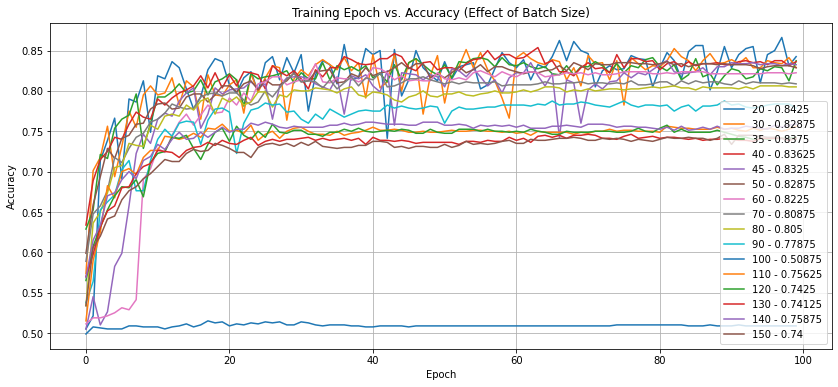

Best batch size: 20


In [4]:
def plot_accuracies_mini_batch_size(save_dir, batch_size_arr):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Training Epoch vs. Accuracy (Effect of Batch Size)")

    fig = plt.figure(figsize=(14, 6))
    plt.title(f"Training Epoch vs. Accuracy (Effect of Batch Size)")
    plt.xlabel("Epoch")
    plt.ylabel('Accuracy')

    best_score = 0
    best_config = None

    for batch_size in batch_size_arr:
        final_scores = []
        epoch_scores = []
        # Run an average over multiple trials
        for i in range(ntrials):
            # Get data and train the network
            training_data, validation_data, testing_data, ndimen = get_data()
            nn = BPNN(best_nc, verbose=False)
            final_score, eval_scores, eval_scores_deltas, conv_time = nn.train(training_data,
                                                                               max_epochs=max_epochs,
                                                                               batch_size=batch_size,
                                                                               learning_rate=init_lr,
                                                                               evaluation_data=validation_data,
                                                                               evaluation_treshold=None)
            final_scores.append(final_score)
            epoch_scores.append(eval_scores)

        # Compute the averages over the specified number of trials
        final_score_avg = np.average(final_scores)
        epoch_scores = np.mean(epoch_scores, axis=0)

        print(f'{batch_size} => {final_score_avg}')
        if final_score_avg > best_score:
            best_score = final_score_avg
            best_config = batch_size
        plt.plot(epoch_scores, label=f'{batch_size} - {final_score_avg}')

    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'{save_dir}/bpnn_batch_vs_acc', dpi=100)

    return best_config


batch_size_arr = [20, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
best_b = plot_accuracies_mini_batch_size("img", batch_size_arr)
print(f"Best batch size: {best_b}")

Training Epoch vs. Accuracy (Effect of Learning Rate)
Training Epoch vs. Accuracy (Effect of Learning Rate)


100%|██████████| 100/100 [38:21<00:00, 23.01s/it]


0.75 => 0.56125


100%|██████████| 100/100 [38:20<00:00, 23.01s/it]


0.65 => 0.81375


100%|██████████| 100/100 [39:51<00:00, 23.91s/it]


0.6 => 0.82625


100%|██████████| 100/100 [34:49<00:00, 20.90s/it]


0.55 => 0.82875


100%|██████████| 100/100 [34:49<00:00, 20.90s/it]


0.5 => 0.81875


100%|██████████| 100/100 [37:13<00:00, 22.34s/it]


0.45 => 0.50125


100%|██████████| 100/100 [34:54<00:00, 20.94s/it]


0.4 => 0.83


100%|██████████| 100/100 [34:47<00:00, 20.87s/it]


0.35 => 0.83375


100%|██████████| 100/100 [38:31<00:00, 23.11s/it]

0.25 => 0.82625


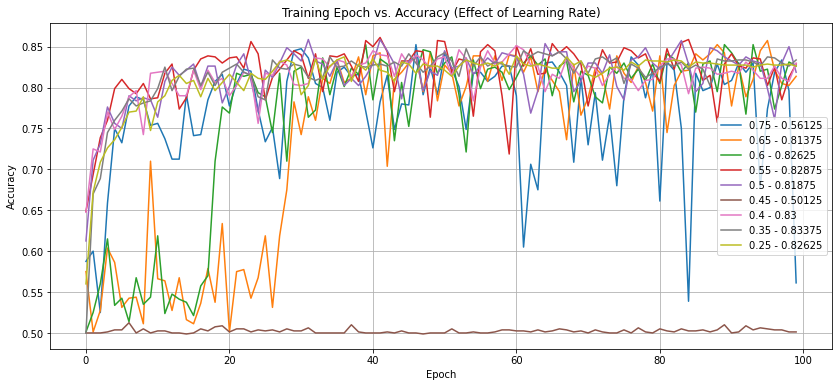

Best learning rate: 0.35


In [5]:
def plot_accuracies_learning_rate(save_dir, learning_rate_arr):
    os.makedirs(save_dir, exist_ok=True)
    print(f"Training Epoch vs. Accuracy (Effect of Learning Rate)")
    print(f"Training Epoch vs. Accuracy (Effect of Learning Rate)")

    fig = plt.figure(figsize=(14, 6))
    plt.title(f"Training Epoch vs. Accuracy (Effect of Learning Rate)")
    plt.xlabel("Epoch")
    plt.ylabel('Accuracy')

    best_score = 0
    best_config = None

    for learning_rate in learning_rate_arr:
        final_scores = []
        epoch_scores = []
        # Run an average over multiple trials
        for i in range(ntrials):
            # Get data and train the network
            training_data, validation_data, testing_data, ndimen = get_data()
            nn = BPNN(best_nc, verbose=False)
            final_score, eval_scores, eval_scores_deltas, conv_time = nn.train(training_data,
                                                                               max_epochs=max_epochs,
                                                                               batch_size=best_b,
                                                                               learning_rate=learning_rate,
                                                                               evaluation_data=validation_data,
                                                                               evaluation_treshold=None)

            final_scores.append(final_score)
            epoch_scores.append(eval_scores)

        # Compute the averages over the specified number of trials
        final_score_avg = np.average(final_scores)
        epoch_scores = np.mean(epoch_scores, axis=0)

        print(f'{learning_rate} => {final_score_avg}')
        if final_score_avg > best_score:
            best_score = final_score_avg
            best_config = learning_rate

        plt.plot(epoch_scores, label=f'{learning_rate} - {final_score_avg}')

    plt.grid()
    plt.legend()
    plt.show()
    fig.savefig(f'{save_dir}/bpnn_lr_vs_acc', dpi=100)

    return best_config


learning_rate_arr = [0.75, 0.65, 0.60, 0.55, 0.5, 0.45, 0.40, 0.35, 0.25]
best_lr = plot_accuracies_learning_rate("img", learning_rate_arr)
print(f"Best learning rate: {best_lr}")

# Training MLP Network: Sizes=[3481, 5000, 2]	Epochs=200	Batch-Size=40	Learning-Rate=0.5
 - Training Data Len: 10000
 - Validation Data Len: 800
# Epochs:


  0%|          | 1/200 [00:30<1:41:10, 30.51s/it]

	1. Correct 462/800	(score: 0.5775	delta: 0.5775	delta_avg: 0.5775)


  1%|          | 2/200 [01:00<1:39:45, 30.23s/it]

	2. Correct 543/800	(score: 0.67875	delta: 0.10124999999999995	delta_avg: 0.339375)


  2%|▏         | 3/200 [01:28<1:35:31, 29.09s/it]

	3. Correct 545/800	(score: 0.68125	delta: 0.0025000000000000577	delta_avg: 0.22708333333333333)


  2%|▏         | 4/200 [01:57<1:34:54, 29.05s/it]

	4. Correct 585/800	(score: 0.73125	delta: 0.04999999999999993	delta_avg: 0.1828125)


  2%|▎         | 5/200 [02:26<1:34:45, 29.15s/it]

	5. Correct 593/800	(score: 0.74125	delta: 0.010000000000000009	delta_avg: 0.14825)


  3%|▎         | 6/200 [02:55<1:33:59, 29.07s/it]

	6. Correct 608/800	(score: 0.76	delta: 0.018750000000000044	delta_avg: 0.12666666666666668)


  4%|▎         | 7/200 [03:24<1:33:11, 28.97s/it]

	7. Correct 614/800	(score: 0.7675	delta: 0.007499999999999951	delta_avg: 0.10964285714285714)


  4%|▍         | 8/200 [03:53<1:32:30, 28.91s/it]

	8. Correct 622/800	(score: 0.7775	delta: 0.010000000000000009	delta_avg: 0.0971875)


  4%|▍         | 9/200 [04:22<1:32:20, 29.01s/it]

	9. Correct 624/800	(score: 0.78	delta: 0.0025000000000000577	delta_avg: 0.08666666666666667)


  5%|▌         | 10/200 [04:49<1:29:56, 28.40s/it]

	10. Correct 632/800	(score: 0.79	delta: 0.010000000000000009	delta_avg: 0.079)


  6%|▌         | 11/200 [05:16<1:27:58, 27.93s/it]

	11. Correct 627/800	(score: 0.78375	delta: -0.006250000000000089	delta_avg: 0.07125)


  6%|▌         | 12/200 [05:45<1:28:44, 28.32s/it]

	12. Correct 622/800	(score: 0.7775	delta: -0.006249999999999978	delta_avg: 0.06479166666666666)


  6%|▋         | 13/200 [06:12<1:27:21, 28.03s/it]

	13. Correct 633/800	(score: 0.79125	delta: 0.01375000000000004	delta_avg: 0.06086538461538461)


  7%|▋         | 14/200 [06:40<1:26:14, 27.82s/it]

	14. Correct 628/800	(score: 0.785	delta: -0.006249999999999978	delta_avg: 0.05607142857142857)


  8%|▊         | 15/200 [07:06<1:24:46, 27.50s/it]

	15. Correct 637/800	(score: 0.79625	delta: 0.011249999999999982	delta_avg: 0.05308333333333334)


  8%|▊         | 16/200 [07:33<1:23:45, 27.31s/it]

	16. Correct 652/800	(score: 0.815	delta: 0.018749999999999933	delta_avg: 0.0509375)


  8%|▊         | 17/200 [08:01<1:23:39, 27.43s/it]

	17. Correct 643/800	(score: 0.80375	delta: -0.011249999999999982	delta_avg: 0.04727941176470588)


  9%|▉         | 18/200 [08:28<1:22:51, 27.32s/it]

	18. Correct 645/800	(score: 0.80625	delta: 0.0025000000000000577	delta_avg: 0.04479166666666667)


 10%|▉         | 19/200 [08:55<1:22:10, 27.24s/it]

	19. Correct 651/800	(score: 0.81375	delta: 0.007499999999999951	delta_avg: 0.04282894736842105)


 10%|█         | 20/200 [09:22<1:21:17, 27.10s/it]

	20. Correct 648/800	(score: 0.81	delta: -0.00374999999999992	delta_avg: 0.0405)


 10%|█         | 21/200 [09:49<1:20:34, 27.01s/it]

	21. Correct 649/800	(score: 0.81125	delta: 0.0012499999999999734	delta_avg: 0.038630952380952384)


 11%|█         | 22/200 [10:15<1:19:53, 26.93s/it]

	22. Correct 660/800	(score: 0.825	delta: 0.013749999999999929	delta_avg: 0.0375)


 12%|█▏        | 23/200 [10:43<1:20:09, 27.18s/it]

	23. Correct 641/800	(score: 0.80125	delta: -0.023749999999999938	delta_avg: 0.03483695652173913)


 12%|█▏        | 24/200 [11:10<1:19:29, 27.10s/it]

	24. Correct 664/800	(score: 0.83	delta: 0.028749999999999942	delta_avg: 0.034583333333333334)


 12%|█▎        | 25/200 [11:37<1:18:53, 27.05s/it]

	25. Correct 668/800	(score: 0.835	delta: 0.0050000000000000044	delta_avg: 0.0334)


 13%|█▎        | 26/200 [12:04<1:18:19, 27.01s/it]

	26. Correct 666/800	(score: 0.8325	delta: -0.0024999999999999467	delta_avg: 0.03201923076923077)


 14%|█▎        | 27/200 [12:32<1:19:08, 27.45s/it]

	27. Correct 666/800	(score: 0.8325	delta: 0.0	delta_avg: 0.030833333333333334)


 14%|█▍        | 28/200 [13:02<1:20:11, 27.97s/it]

	28. Correct 669/800	(score: 0.83625	delta: 0.003750000000000031	delta_avg: 0.02986607142857143)


 14%|█▍        | 29/200 [13:33<1:22:42, 29.02s/it]

	29. Correct 669/800	(score: 0.83625	delta: 0.0	delta_avg: 0.028836206896551725)


 15%|█▌        | 30/200 [14:01<1:21:12, 28.66s/it]

	30. Correct 653/800	(score: 0.81625	delta: -0.020000000000000018	delta_avg: 0.027208333333333334)


 16%|█▌        | 31/200 [14:28<1:19:10, 28.11s/it]

	31. Correct 677/800	(score: 0.84625	delta: 0.029999999999999916	delta_avg: 0.027298387096774193)


 16%|█▌        | 32/200 [14:54<1:17:33, 27.70s/it]

	32. Correct 680/800	(score: 0.85	delta: 0.003750000000000031	delta_avg: 0.0265625)


 16%|█▋        | 33/200 [15:21<1:16:34, 27.51s/it]

	33. Correct 668/800	(score: 0.835	delta: -0.015000000000000013	delta_avg: 0.025303030303030303)


 17%|█▋        | 34/200 [15:50<1:17:07, 27.88s/it]

	34. Correct 671/800	(score: 0.83875	delta: 0.003750000000000031	delta_avg: 0.024669117647058824)


 18%|█▊        | 35/200 [16:17<1:16:00, 27.64s/it]

	35. Correct 675/800	(score: 0.84375	delta: 0.0050000000000000044	delta_avg: 0.024107142857142858)


 18%|█▊        | 36/200 [16:44<1:15:08, 27.49s/it]

	36. Correct 676/800	(score: 0.845	delta: 0.0012499999999999734	delta_avg: 0.02347222222222222)


 18%|█▊        | 37/200 [17:12<1:14:24, 27.39s/it]

	37. Correct 669/800	(score: 0.83625	delta: -0.008749999999999925	delta_avg: 0.022601351351351353)


 19%|█▉        | 38/200 [17:39<1:13:42, 27.30s/it]

	38. Correct 664/800	(score: 0.83	delta: -0.006250000000000089	delta_avg: 0.021842105263157895)


 20%|█▉        | 39/200 [18:09<1:15:26, 28.12s/it]

	39. Correct 673/800	(score: 0.84125	delta: 0.011250000000000093	delta_avg: 0.02157051282051282)


 20%|██        | 40/200 [18:36<1:14:02, 27.76s/it]

	40. Correct 676/800	(score: 0.845	delta: 0.00374999999999992	delta_avg: 0.021124999999999998)


 20%|██        | 41/200 [19:03<1:12:58, 27.54s/it]

	41. Correct 665/800	(score: 0.83125	delta: -0.013749999999999929	delta_avg: 0.02027439024390244)


 21%|██        | 42/200 [19:31<1:13:04, 27.75s/it]

	42. Correct 668/800	(score: 0.835	delta: 0.00374999999999992	delta_avg: 0.01988095238095238)


 22%|██▏       | 43/200 [19:58<1:11:55, 27.49s/it]

	43. Correct 683/800	(score: 0.85375	delta: 0.018750000000000044	delta_avg: 0.0198546511627907)


 22%|██▏       | 44/200 [20:25<1:11:00, 27.31s/it]

	44. Correct 682/800	(score: 0.8525	delta: -0.0012499999999999734	delta_avg: 0.019375)


 22%|██▎       | 45/200 [20:52<1:10:18, 27.22s/it]

	45. Correct 674/800	(score: 0.8425	delta: -0.010000000000000009	delta_avg: 0.018722222222222223)


 23%|██▎       | 46/200 [21:19<1:10:12, 27.35s/it]

	46. Correct 662/800	(score: 0.8275	delta: -0.015000000000000013	delta_avg: 0.017989130434782608)


 24%|██▎       | 47/200 [21:47<1:09:51, 27.39s/it]

	47. Correct 681/800	(score: 0.85125	delta: 0.023749999999999938	delta_avg: 0.018111702127659574)


 24%|██▍       | 48/200 [22:14<1:08:59, 27.23s/it]

	48. Correct 684/800	(score: 0.855	delta: 0.003750000000000031	delta_avg: 0.0178125)


 24%|██▍       | 49/200 [22:41<1:08:47, 27.34s/it]

	49. Correct 677/800	(score: 0.84625	delta: -0.008750000000000036	delta_avg: 0.017270408163265305)


 25%|██▌       | 50/200 [23:09<1:08:45, 27.50s/it]

	50. Correct 679/800	(score: 0.84875	delta: 0.0025000000000000577	delta_avg: 0.016975)


 26%|██▌       | 51/200 [23:37<1:08:42, 27.67s/it]

	51. Correct 677/800	(score: 0.84625	delta: -0.0025000000000000577	delta_avg: 0.016593137254901958)


 26%|██▌       | 52/200 [24:05<1:08:11, 27.64s/it]

	52. Correct 682/800	(score: 0.8525	delta: 0.006250000000000089	delta_avg: 0.01639423076923077)


 26%|██▋       | 53/200 [24:34<1:09:00, 28.17s/it]

	53. Correct 685/800	(score: 0.85625	delta: 0.00374999999999992	delta_avg: 0.01615566037735849)


 27%|██▋       | 54/200 [25:02<1:08:05, 27.99s/it]

	54. Correct 675/800	(score: 0.84375	delta: -0.012499999999999956	delta_avg: 0.015625)


 28%|██▊       | 55/200 [25:29<1:06:46, 27.63s/it]

	55. Correct 687/800	(score: 0.85875	delta: 0.015000000000000013	delta_avg: 0.015613636363636364)


 28%|██▊       | 56/200 [25:55<1:05:41, 27.37s/it]

	56. Correct 672/800	(score: 0.84	delta: -0.018750000000000044	delta_avg: 0.015)


 28%|██▊       | 57/200 [26:22<1:04:59, 27.27s/it]

	57. Correct 676/800	(score: 0.845	delta: 0.0050000000000000044	delta_avg: 0.014824561403508772)


 29%|██▉       | 58/200 [26:49<1:04:18, 27.18s/it]

	58. Correct 684/800	(score: 0.855	delta: 0.010000000000000009	delta_avg: 0.014741379310344827)


 30%|██▉       | 59/200 [27:16<1:03:33, 27.05s/it]

	59. Correct 687/800	(score: 0.85875	delta: 0.003750000000000031	delta_avg: 0.014555084745762711)


 30%|███       | 60/200 [27:43<1:02:54, 26.96s/it]

	60. Correct 682/800	(score: 0.8525	delta: -0.006249999999999978	delta_avg: 0.014208333333333333)


 30%|███       | 61/200 [28:11<1:03:13, 27.29s/it]

	61. Correct 680/800	(score: 0.85	delta: -0.0025000000000000577	delta_avg: 0.013934426229508197)


 31%|███       | 62/200 [28:38<1:02:32, 27.19s/it]

	62. Correct 680/800	(score: 0.85	delta: 0.0	delta_avg: 0.013709677419354839)


 32%|███▏      | 63/200 [29:05<1:02:17, 27.28s/it]

	63. Correct 680/800	(score: 0.85	delta: 0.0	delta_avg: 0.013492063492063491)


 32%|███▏      | 64/200 [29:32<1:01:33, 27.16s/it]

	64. Correct 672/800	(score: 0.84	delta: -0.010000000000000009	delta_avg: 0.013125)


 32%|███▎      | 65/200 [29:59<1:00:54, 27.07s/it]

	65. Correct 680/800	(score: 0.85	delta: 0.010000000000000009	delta_avg: 0.013076923076923076)


 33%|███▎      | 66/200 [30:26<1:00:18, 27.00s/it]

	66. Correct 694/800	(score: 0.8675	delta: 0.01750000000000007	delta_avg: 0.013143939393939395)


 34%|███▎      | 67/200 [30:53<59:46, 26.96s/it]  

	67. Correct 680/800	(score: 0.85	delta: -0.01750000000000007	delta_avg: 0.012686567164179104)


 34%|███▍      | 68/200 [31:20<59:16, 26.94s/it]

	68. Correct 680/800	(score: 0.85	delta: 0.0	delta_avg: 0.012499999999999999)


 34%|███▍      | 69/200 [31:47<58:46, 26.92s/it]

	69. Correct 678/800	(score: 0.8475	delta: -0.0024999999999999467	delta_avg: 0.012282608695652175)


 35%|███▌      | 70/200 [32:13<58:17, 26.90s/it]

	70. Correct 687/800	(score: 0.85875	delta: 0.011249999999999982	delta_avg: 0.012267857142857143)


 36%|███▌      | 71/200 [32:40<57:48, 26.89s/it]

	71. Correct 680/800	(score: 0.85	delta: -0.008750000000000036	delta_avg: 0.011971830985915493)


 36%|███▌      | 72/200 [33:07<57:20, 26.88s/it]

	72. Correct 681/800	(score: 0.85125	delta: 0.0012499999999999734	delta_avg: 0.011822916666666666)


 36%|███▋      | 73/200 [33:34<56:55, 26.89s/it]

	73. Correct 678/800	(score: 0.8475	delta: -0.00374999999999992	delta_avg: 0.01160958904109589)


 37%|███▋      | 74/200 [34:01<56:27, 26.88s/it]

	74. Correct 686/800	(score: 0.8575	delta: 0.010000000000000009	delta_avg: 0.01158783783783784)


 38%|███▊      | 75/200 [34:28<55:59, 26.88s/it]

	75. Correct 681/800	(score: 0.85125	delta: -0.006250000000000089	delta_avg: 0.011349999999999999)


 38%|███▊      | 76/200 [34:55<55:32, 26.87s/it]

	76. Correct 681/800	(score: 0.85125	delta: 0.0	delta_avg: 0.011200657894736841)


 38%|███▊      | 77/200 [35:21<55:04, 26.87s/it]

	77. Correct 678/800	(score: 0.8475	delta: -0.00374999999999992	delta_avg: 0.011006493506493508)


 39%|███▉      | 78/200 [35:48<54:37, 26.87s/it]

	78. Correct 681/800	(score: 0.85125	delta: 0.00374999999999992	delta_avg: 0.010913461538461539)


 40%|███▉      | 79/200 [36:15<54:11, 26.87s/it]

	79. Correct 676/800	(score: 0.845	delta: -0.006249999999999978	delta_avg: 0.01069620253164557)


 40%|████      | 80/200 [36:42<53:44, 26.87s/it]

	80. Correct 680/800	(score: 0.85	delta: 0.0050000000000000044	delta_avg: 0.010624999999999999)


 40%|████      | 81/200 [37:09<53:19, 26.88s/it]

	81. Correct 681/800	(score: 0.85125	delta: 0.0012499999999999734	delta_avg: 0.010509259259259258)


 41%|████      | 82/200 [37:36<52:51, 26.88s/it]

	82. Correct 676/800	(score: 0.845	delta: -0.006249999999999978	delta_avg: 0.010304878048780488)


 42%|████▏     | 83/200 [38:03<52:24, 26.88s/it]

	83. Correct 672/800	(score: 0.84	delta: -0.0050000000000000044	delta_avg: 0.010120481927710843)


 42%|████▏     | 84/200 [38:30<51:57, 26.88s/it]

	84. Correct 679/800	(score: 0.84875	delta: 0.008750000000000036	delta_avg: 0.010104166666666668)


 42%|████▎     | 85/200 [38:57<51:30, 26.88s/it]

	85. Correct 680/800	(score: 0.85	delta: 0.0012499999999999734	delta_avg: 0.01)


 43%|████▎     | 86/200 [39:23<51:03, 26.87s/it]

	86. Correct 677/800	(score: 0.84625	delta: -0.003750000000000031	delta_avg: 0.009840116279069767)


 44%|████▎     | 87/200 [39:50<50:35, 26.87s/it]

	87. Correct 677/800	(score: 0.84625	delta: 0.0	delta_avg: 0.009727011494252874)


 44%|████▍     | 88/200 [40:17<50:08, 26.86s/it]

	88. Correct 673/800	(score: 0.84125	delta: -0.004999999999999893	delta_avg: 0.009559659090909091)


 44%|████▍     | 89/200 [40:44<49:41, 26.86s/it]

	89. Correct 676/800	(score: 0.845	delta: 0.00374999999999992	delta_avg: 0.00949438202247191)


 45%|████▌     | 90/200 [41:11<49:14, 26.85s/it]

	90. Correct 688/800	(score: 0.86	delta: 0.015000000000000013	delta_avg: 0.009555555555555555)


 46%|████▌     | 91/200 [41:38<48:47, 26.85s/it]

	91. Correct 682/800	(score: 0.8525	delta: -0.007499999999999951	delta_avg: 0.009368131868131869)


 46%|████▌     | 92/200 [42:04<48:20, 26.86s/it]

	92. Correct 687/800	(score: 0.85875	delta: 0.006249999999999978	delta_avg: 0.009334239130434782)


 46%|████▋     | 93/200 [42:31<47:54, 26.86s/it]

	93. Correct 687/800	(score: 0.85875	delta: 0.0	delta_avg: 0.009233870967741935)


 47%|████▋     | 94/200 [42:58<47:27, 26.86s/it]

	94. Correct 681/800	(score: 0.85125	delta: -0.007500000000000062	delta_avg: 0.009055851063829787)


 48%|████▊     | 95/200 [43:26<47:13, 26.99s/it]

	95. Correct 678/800	(score: 0.8475	delta: -0.00374999999999992	delta_avg: 0.008921052631578948)


 48%|████▊     | 96/200 [43:51<46:00, 26.55s/it]

	96. Correct 686/800	(score: 0.8575	delta: 0.010000000000000009	delta_avg: 0.008932291666666667)


 48%|████▊     | 97/200 [44:17<45:02, 26.24s/it]

	97. Correct 685/800	(score: 0.85625	delta: -0.0012500000000000844	delta_avg: 0.008827319587628866)


 49%|████▉     | 98/200 [44:42<44:13, 26.02s/it]

	98. Correct 682/800	(score: 0.8525	delta: -0.00374999999999992	delta_avg: 0.008698979591836735)


 50%|████▉     | 99/200 [45:08<43:32, 25.86s/it]

	99. Correct 682/800	(score: 0.8525	delta: 0.0	delta_avg: 0.008611111111111111)


 50%|█████     | 100/200 [45:33<42:55, 25.76s/it]

	100. Correct 682/800	(score: 0.8525	delta: 0.0	delta_avg: 0.008525)


 50%|█████     | 101/200 [45:59<42:22, 25.68s/it]

	101. Correct 682/800	(score: 0.8525	delta: 0.0	delta_avg: 0.008440594059405941)


 51%|█████     | 102/200 [46:24<41:51, 25.63s/it]

	102. Correct 680/800	(score: 0.85	delta: -0.0025000000000000577	delta_avg: 0.008333333333333333)


 52%|█████▏    | 103/200 [46:52<42:41, 26.41s/it]

	103. Correct 684/800	(score: 0.855	delta: 0.0050000000000000044	delta_avg: 0.008300970873786407)


 52%|█████▏    | 104/200 [47:21<43:16, 27.05s/it]

	104. Correct 685/800	(score: 0.85625	delta: 0.0012499999999999734	delta_avg: 0.008233173076923077)


 52%|█████▎    | 105/200 [47:48<42:51, 27.07s/it]

	105. Correct 684/800	(score: 0.855	delta: -0.0012499999999999734	delta_avg: 0.008142857142857143)


 53%|█████▎    | 106/200 [48:15<42:22, 27.05s/it]

	106. Correct 684/800	(score: 0.855	delta: 0.0	delta_avg: 0.008066037735849057)


 54%|█████▎    | 107/200 [48:43<42:15, 27.26s/it]

	107. Correct 685/800	(score: 0.85625	delta: 0.0012499999999999734	delta_avg: 0.00800233644859813)


 54%|█████▍    | 108/200 [49:15<43:55, 28.65s/it]

	108. Correct 685/800	(score: 0.85625	delta: 0.0	delta_avg: 0.007928240740740741)


 55%|█████▍    | 109/200 [49:48<45:27, 29.97s/it]

	109. Correct 684/800	(score: 0.855	delta: -0.0012499999999999734	delta_avg: 0.007844036697247706)


 55%|█████▌    | 110/200 [50:18<45:08, 30.09s/it]

	110. Correct 684/800	(score: 0.855	delta: 0.0	delta_avg: 0.007772727272727272)


 56%|█████▌    | 111/200 [50:46<43:43, 29.48s/it]

	111. Correct 684/800	(score: 0.855	delta: 0.0	delta_avg: 0.007702702702702703)


 56%|█████▌    | 112/200 [51:14<42:42, 29.11s/it]

	112. Correct 685/800	(score: 0.85625	delta: 0.0012499999999999734	delta_avg: 0.0076450892857142854)


 56%|█████▋    | 113/200 [51:43<41:48, 28.84s/it]

	113. Correct 685/800	(score: 0.85625	delta: 0.0	delta_avg: 0.0075774336283185835)


 57%|█████▋    | 114/200 [52:12<41:43, 29.11s/it]

	114. Correct 685/800	(score: 0.85625	delta: 0.0	delta_avg: 0.007510964912280702)


 57%|█████▊    | 115/200 [52:44<42:08, 29.75s/it]

	115. Correct 686/800	(score: 0.8575	delta: 0.0012500000000000844	delta_avg: 0.0074565217391304355)


 58%|█████▊    | 116/200 [53:12<41:08, 29.39s/it]

	116. Correct 687/800	(score: 0.85875	delta: 0.0012499999999999734	delta_avg: 0.00740301724137931)


 58%|█████▊    | 117/200 [53:44<41:31, 30.02s/it]

	117. Correct 687/800	(score: 0.85875	delta: 0.0	delta_avg: 0.00733974358974359)


 59%|█████▉    | 118/200 [54:15<41:40, 30.50s/it]

	118. Correct 687/800	(score: 0.85875	delta: 0.0	delta_avg: 0.007277542372881356)


 60%|█████▉    | 119/200 [54:43<40:05, 29.69s/it]

	119. Correct 687/800	(score: 0.85875	delta: 0.0	delta_avg: 0.007216386554621848)


 60%|██████    | 120/200 [55:12<39:25, 29.57s/it]

	120. Correct 687/800	(score: 0.85875	delta: 0.0	delta_avg: 0.00715625)


 60%|██████    | 121/200 [55:42<39:06, 29.71s/it]

	121. Correct 687/800	(score: 0.85875	delta: 0.0	delta_avg: 0.007097107438016529)


 61%|██████    | 122/200 [56:10<38:01, 29.25s/it]

	122. Correct 689/800	(score: 0.86125	delta: 0.0024999999999999467	delta_avg: 0.007059426229508196)


 62%|██████▏   | 123/200 [56:38<36:59, 28.83s/it]

	123. Correct 688/800	(score: 0.86	delta: -0.0012499999999999734	delta_avg: 0.0069918699186991866)


 62%|██████▏   | 124/200 [57:07<36:17, 28.65s/it]

	124. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.006935483870967742)


 62%|██████▎   | 125/200 [57:34<35:30, 28.40s/it]

	125. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.00688)


 63%|██████▎   | 126/200 [58:02<34:51, 28.26s/it]

	126. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.006825396825396826)


 64%|██████▎   | 127/200 [58:32<34:50, 28.63s/it]

	127. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.006771653543307087)


 64%|██████▍   | 128/200 [59:02<34:57, 29.13s/it]

	128. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.00671875)


 64%|██████▍   | 129/200 [59:30<33:52, 28.62s/it]

	129. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.006666666666666666)


 65%|██████▌   | 130/200 [59:57<33:00, 28.29s/it]

	130. Correct 687/800	(score: 0.85875	delta: -0.0012499999999999734	delta_avg: 0.006605769230769231)


 66%|██████▌   | 131/200 [1:00:24<32:13, 28.03s/it]

	131. Correct 688/800	(score: 0.86	delta: 0.0012499999999999734	delta_avg: 0.006564885496183206)


 66%|██████▌   | 132/200 [1:00:52<31:33, 27.85s/it]

	132. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.0065151515151515155)


 66%|██████▋   | 133/200 [1:01:20<31:14, 27.98s/it]

	133. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.006466165413533834)


 67%|██████▋   | 134/200 [1:01:48<30:36, 27.83s/it]

	134. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.006417910447761194)


 68%|██████▊   | 135/200 [1:02:15<30:03, 27.74s/it]

	135. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.00637037037037037)


 68%|██████▊   | 136/200 [1:02:43<29:30, 27.67s/it]

	136. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.006323529411764706)


 68%|██████▊   | 137/200 [1:03:10<28:59, 27.61s/it]

	137. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.006277372262773723)


 69%|██████▉   | 138/200 [1:03:38<28:27, 27.55s/it]

	138. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.006231884057971014)


 70%|██████▉   | 139/200 [1:04:05<27:58, 27.52s/it]

	139. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.00618705035971223)


 70%|███████   | 140/200 [1:04:32<27:29, 27.49s/it]

	140. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.006142857142857143)


 70%|███████   | 141/200 [1:05:00<27:03, 27.52s/it]

	141. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.006099290780141844)


 71%|███████   | 142/200 [1:05:27<26:34, 27.49s/it]

	142. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.006056338028169014)


 72%|███████▏  | 143/200 [1:05:56<26:22, 27.77s/it]

	143. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.0060139860139860135)


 72%|███████▏  | 144/200 [1:06:25<26:11, 28.06s/it]

	144. Correct 690/800	(score: 0.8625	delta: 0.0025000000000000577	delta_avg: 0.005989583333333334)


 72%|███████▎  | 145/200 [1:06:53<25:42, 28.04s/it]

	145. Correct 686/800	(score: 0.8575	delta: -0.0050000000000000044	delta_avg: 0.0059137931034482765)


 73%|███████▎  | 146/200 [1:07:20<25:06, 27.90s/it]

	146. Correct 688/800	(score: 0.86	delta: 0.0024999999999999467	delta_avg: 0.005890410958904109)


 74%|███████▎  | 147/200 [1:07:49<24:50, 28.12s/it]

	147. Correct 690/800	(score: 0.8625	delta: 0.0025000000000000577	delta_avg: 0.00586734693877551)


 74%|███████▍  | 148/200 [1:08:17<24:24, 28.16s/it]

	148. Correct 689/800	(score: 0.86125	delta: -0.0012500000000000844	delta_avg: 0.005819256756756756)


 74%|███████▍  | 149/200 [1:08:45<23:52, 28.10s/it]

	149. Correct 688/800	(score: 0.86	delta: -0.0012499999999999734	delta_avg: 0.0057718120805369125)


 75%|███████▌  | 150/200 [1:09:13<23:20, 28.01s/it]

	150. Correct 689/800	(score: 0.86125	delta: 0.0012499999999999734	delta_avg: 0.005741666666666667)


 76%|███████▌  | 151/200 [1:09:43<23:23, 28.65s/it]

	151. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.00570364238410596)


 76%|███████▌  | 152/200 [1:10:13<23:17, 29.11s/it]

	152. Correct 688/800	(score: 0.86	delta: -0.0012499999999999734	delta_avg: 0.005657894736842105)


 76%|███████▋  | 153/200 [1:10:42<22:48, 29.11s/it]

	153. Correct 689/800	(score: 0.86125	delta: 0.0012499999999999734	delta_avg: 0.0056290849673202616)


 77%|███████▋  | 154/200 [1:11:13<22:45, 29.68s/it]

	154. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.0055925324675324675)


 78%|███████▊  | 155/200 [1:11:43<22:14, 29.65s/it]

	155. Correct 690/800	(score: 0.8625	delta: 0.0012500000000000844	delta_avg: 0.005564516129032258)


 78%|███████▊  | 156/200 [1:12:11<21:30, 29.32s/it]

	156. Correct 690/800	(score: 0.8625	delta: 0.0	delta_avg: 0.005528846153846154)


 78%|███████▊  | 157/200 [1:12:40<20:55, 29.19s/it]

	157. Correct 690/800	(score: 0.8625	delta: 0.0	delta_avg: 0.005493630573248408)


 79%|███████▉  | 158/200 [1:13:08<20:09, 28.81s/it]

	158. Correct 690/800	(score: 0.8625	delta: 0.0	delta_avg: 0.005458860759493671)


 80%|███████▉  | 159/200 [1:13:36<19:30, 28.54s/it]

	159. Correct 690/800	(score: 0.8625	delta: 0.0	delta_avg: 0.005424528301886793)


 80%|████████  | 160/200 [1:14:05<19:06, 28.67s/it]

	160. Correct 689/800	(score: 0.86125	delta: -0.0012500000000000844	delta_avg: 0.0053828125)


 80%|████████  | 161/200 [1:14:33<18:34, 28.58s/it]

	161. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.005349378881987578)


 81%|████████  | 162/200 [1:15:02<18:04, 28.54s/it]

	162. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.005316358024691358)


 82%|████████▏ | 163/200 [1:15:30<17:34, 28.49s/it]

	163. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.005283742331288343)


 82%|████████▏ | 164/200 [1:15:59<17:03, 28.44s/it]

	164. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.005251524390243902)


 82%|████████▎ | 165/200 [1:16:27<16:33, 28.40s/it]

	165. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.00521969696969697)


 83%|████████▎ | 166/200 [1:16:55<16:05, 28.39s/it]

	166. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.005188253012048193)


 84%|████████▎ | 167/200 [1:17:24<15:36, 28.38s/it]

	167. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.0051571856287425145)


 84%|████████▍ | 168/200 [1:17:52<15:08, 28.38s/it]

	168. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.005126488095238095)


 84%|████████▍ | 169/200 [1:18:20<14:39, 28.37s/it]

	169. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.005096153846153846)


 85%|████████▌ | 170/200 [1:18:49<14:10, 28.36s/it]

	170. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.005066176470588235)


 86%|████████▌ | 171/200 [1:19:17<13:42, 28.35s/it]

	171. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.005036549707602339)


 86%|████████▌ | 172/200 [1:19:45<13:13, 28.35s/it]

	172. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.005007267441860465)


 86%|████████▋ | 173/200 [1:20:14<12:46, 28.39s/it]

	173. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.004978323699421965)


 87%|████████▋ | 174/200 [1:20:42<12:17, 28.37s/it]

	174. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.0049497126436781605)


 88%|████████▊ | 175/200 [1:21:11<11:48, 28.36s/it]

	175. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.004921428571428571)


 88%|████████▊ | 176/200 [1:21:39<11:20, 28.35s/it]

	176. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.004893465909090909)


 88%|████████▊ | 177/200 [1:22:07<10:51, 28.34s/it]

	177. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.004865819209039548)


 89%|████████▉ | 178/200 [1:22:35<10:23, 28.33s/it]

	178. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.004838483146067415)


 90%|████████▉ | 179/200 [1:23:04<09:55, 28.34s/it]

	179. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.00481145251396648)


 90%|█████████ | 180/200 [1:23:32<09:26, 28.33s/it]

	180. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.004784722222222222)


 90%|█████████ | 181/200 [1:24:00<08:58, 28.34s/it]

	181. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.00475828729281768)


 91%|█████████ | 182/200 [1:24:29<08:29, 28.33s/it]

	182. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.004732142857142857)


 92%|█████████▏| 183/200 [1:24:58<08:05, 28.56s/it]

	183. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.004706284153005464)


 92%|█████████▏| 184/200 [1:25:26<07:36, 28.51s/it]

	184. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.00468070652173913)


 92%|█████████▎| 185/200 [1:25:55<07:06, 28.45s/it]

	185. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.004655405405405405)


 93%|█████████▎| 186/200 [1:26:23<06:38, 28.44s/it]

	186. Correct 689/800	(score: 0.86125	delta: 0.0	delta_avg: 0.004630376344086021)


 94%|█████████▎| 187/200 [1:26:51<06:09, 28.41s/it]

	187. Correct 688/800	(score: 0.86	delta: -0.0012499999999999734	delta_avg: 0.004598930481283422)


 94%|█████████▍| 188/200 [1:27:20<05:40, 28.39s/it]

	188. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.004574468085106383)


 94%|█████████▍| 189/200 [1:27:48<05:12, 28.37s/it]

	189. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.00455026455026455)


 95%|█████████▌| 190/200 [1:28:16<04:43, 28.36s/it]

	190. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.004526315789473684)


 96%|█████████▌| 191/200 [1:28:45<04:15, 28.38s/it]

	191. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.0045026178010471206)


 96%|█████████▌| 192/200 [1:29:14<03:48, 28.55s/it]

	192. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.004479166666666667)


 96%|█████████▋| 193/200 [1:29:40<03:14, 27.82s/it]

	193. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.004455958549222798)


 97%|█████████▋| 194/200 [1:30:06<02:43, 27.33s/it]

	194. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.004432989690721649)


 98%|█████████▊| 195/200 [1:30:32<02:14, 26.97s/it]

	195. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.00441025641025641)


 98%|█████████▊| 196/200 [1:30:58<01:46, 26.72s/it]

	196. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.004387755102040816)


 98%|█████████▊| 197/200 [1:31:24<01:19, 26.54s/it]

	197. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.004365482233502538)


 99%|█████████▉| 198/200 [1:31:51<00:52, 26.41s/it]

	198. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.004343434343434344)


100%|█████████▉| 199/200 [1:32:17<00:26, 26.32s/it]

	199. Correct 688/800	(score: 0.86	delta: 0.0	delta_avg: 0.004321608040201005)


100%|██████████| 200/200 [1:32:43<00:00, 27.82s/it]

	200. Correct 689/800	(score: 0.86125	delta: 0.0012499999999999734	delta_avg: 0.00430625)
Converged in 200 epochs with accuracy 0.86125 took 5563.27 sec


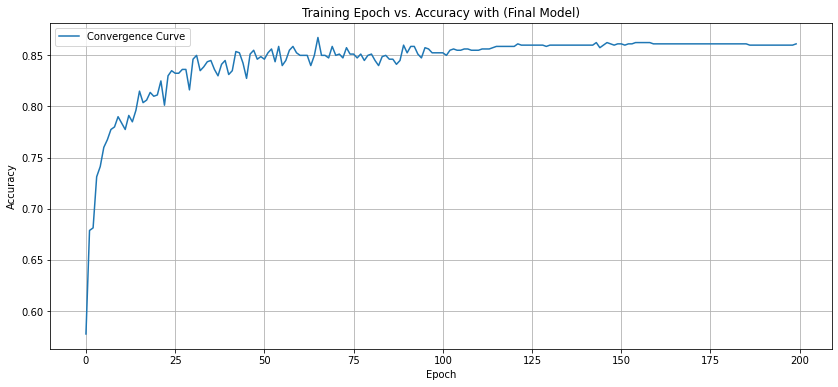

Overall Testing Accuracy: 0.8487903225806451
Class 0 Testing Accuracy: 0.862475442043222
Class 1 Testing Accuracy: 0.8343685300207039


In [6]:
"""
Plot the convergence curve of BPNN
"""

training_data, validation_data, testing_data, ndimen = get_data()

nn = BPNN([ndimen, 5000, 2], verbose=True)
final_score, eval_scores, eval_scores_deltas, nn_conv_time = nn.train(training_data,
                                                                      max_epochs=200,
                                                                      batch_size=40,
                                                                      learning_rate=0.5,
                                                                      evaluation_data=validation_data,
                                                                      evaluation_treshold=None)

fig = plt.figure(figsize=(14, 6))

plt.title(f"Training Epoch vs. Accuracy with (Final Model)")
plt.xlabel("Epoch")
plt.ylabel('Accuracy')

plt.plot(eval_scores, label='Convergence Curve')

plt.grid()
plt.legend()
plt.show()
fig.savefig(f'img/bpnn_best_model', dpi=100)


In [40]:
import gzip

# make directory to save generated images to
os.makedirs('models', exist_ok=True)

def save_best_model():
    # Save the best BPNN model to a pickle file
    with gzip.open('models/bpnn_best_model.pkl.gzip', 'wb') as f:
        pickle.dump(nn, f)
    
def save_testing_pred(data):
    # Tuples (X, y, y_pred)
    
    new_data = []
    for (x, y) in data:
        decision = np.argmax(nn.feedforward(x))
        new_data.append((x, y, decision))
        
    with gzip.open('models/bpnn_testing_pred.pkl.gzip', 'wb') as f:
        pickle.dump(new_data, f)


training_data, validation_data, testing_data, ndimen = get_data()
save_best_model()
save_testing_pred(testing_data)


In [42]:
def evaluate(dataset):

    acc = 0
    acc0 = 0
    len0 = 0
    acc1 = 0
    len1 = 0

    for (x, y) in dataset:
        decision = np.argmax(nn.feedforward(x))

        if decision == y:
            acc += 1
        if y == 0:
            len0 += 1
            if decision == y:
                acc0 += 1
        if y == 1:
            len1 += 1
            if decision == y:
                acc1 += 1

    nn_acc = acc / (len0 + len1)
    # Compute class accuracies
    nn_acc0 = acc0 / len0
    nn_acc1 = acc1 / len1

    print(f'Overall Testing Accuracy: {nn_acc}')
    print(f'Class 0 Testing Accuracy: {nn_acc0}')
    print(f'Class 1 Testing Accuracy: {nn_acc1}')
    
    return nn_acc, nn_acc0, nn_acc1


training_data, validation_data, testing_data, ndimen = get_data()


vnn_acc, vnn_acc0, vnn_acc1 = evaluate(validation_data)
print()
tnn_acc, tnn_acc0, tnn_acc1 = evaluate(testing_data)



FileNotFoundError: [Errno 2] No such file or directory: 'datasets/face_mask_pickled/dataset_gray_conv.pkl.gzip'

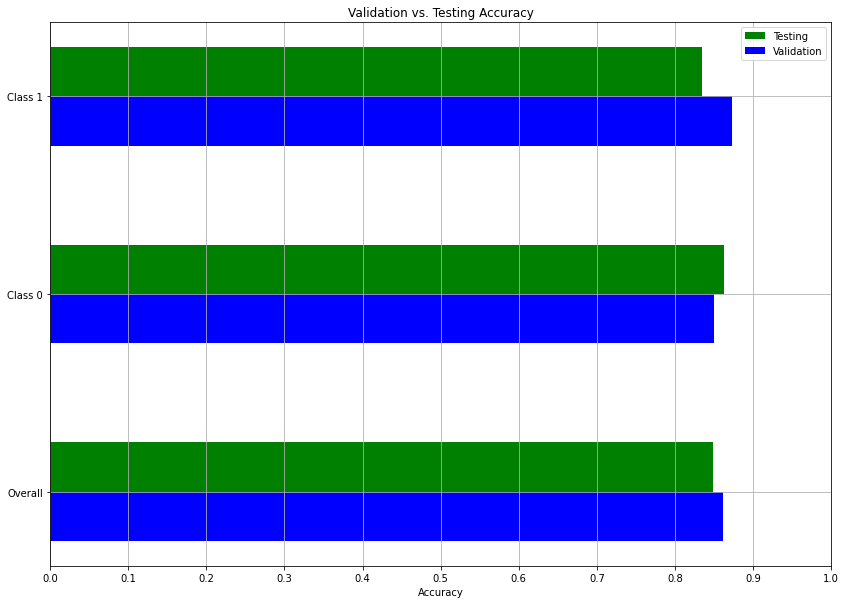

In [35]:
# Plot a barchart comparing the validation vs testing accuracies overall, for class 0, and for class 1 side by side

# set the y axis major ticks to .1 and minor ticks to .01
major_ticks = np.arange(0, 1.1, 0.1)
minor_ticks = np.arange(0, 1.1, 0.01)



fig = plt.figure(figsize=(14, 10))

plt.title(f"Validation vs. Testing Accuracy")
plt.xlabel("Accuracy")

width = 0.25
plt.barh(0 + width/2, tnn_acc, width, label='Testing', color='green')
plt.barh(0 - width/2, vnn_acc, width, label='Validation', color='blue')

plt.barh(1 + width/2, tnn_acc0, width, color='green')
plt.barh(1 - width/2, vnn_acc0, width, color='blue')

plt.barh(2 + width/2, tnn_acc1, width, color='green')
plt.barh(2 - width/2, vnn_acc1, width, color='blue')

plt.yticks(np.arange(0, 3, 1), ['Overall', 'Class 0', 'Class 1'])
plt.xticks(major_ticks)
plt.grid()
plt.legend()
plt.show()
fig.savefig(f'img/bpnn_validation_vs_testing', dpi=100)
